In [ ]:
# do_sample을 False로 설정한다면 Search (최대화 기법)으로 추론 진행
# do_sample=True로 설정하면 Sampling 기법으로 추론 진행

# num_return_sequence는 생성 문장들 가운데 몇 개를 결과로 받을 것인지 선택하는 것으로, num_return < num_beams 여야 함

In [ ]:
# 문장을 decoding하는 데 사용되는 대표적인 알고리즘으로, 토큰의 시퀀스 출력 생성을 목표

# GPT와 같은 decoder model 혹은 Seq2seq 모델의 decoder에서 사용
# 생성 모델은 generate() 함수를 통해 다음 token을 생성

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

# Greedy search

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42);
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_name = "gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
input_txt = "I enjoy walking with my cute dog"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
# 텍스트를 생성하기 위한 반복 (단계)의 수
n_steps = 8
# 상위 선택 항목을 몇 개 고려할 것인지
choices_per_step = 5

In [ ]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,I enjoy walking with my cute dog,", (18.03%)",. (12.05%),and (10.12%),on (4.16%),in (3.35%)
1,"I enjoy walking with my cute dog,",and (4.34%),but (3.91%),so (1.31%),who (1.30%),L (0.97%)
2,"I enjoy walking with my cute dog, and",I (27.42%),it (4.73%),the (3.15%),he (2.86%),she (2.71%)
3,"I enjoy walking with my cute dog, and I",love (17.41%),'m (7.09%),like (5.52%),enjoy (5.39%),have (4.65%)
4,"I enjoy walking with my cute dog, and I love",to (13.92%),the (11.27%),my (3.58%),being (3.34%),going (3.30%)
5,"I enjoy walking with my cute dog, and I love to",go (6.47%),read (5.43%),walk (5.24%),play (4.43%),run (3.69%)
6,"I enjoy walking with my cute dog, and I love t...",for (20.44%),to (18.24%),on (16.85%),hiking (6.78%),out (5.86%)
7,"I enjoy walking with my cute dog, and I love t...",a (43.23%),walks (31.43%),long (5.03%),hikes (3.70%),runs (3.58%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

I enjoy walking with my cute dog, and I love to go for a


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home


# Beam Search

In [ ]:
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
# 모델에서 생성된 토큰 시퀀스의 로그 확률을 계산

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

로그 확률: -86.50


In [ ]:
# num_beams = 5로 설정

output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the University of California, Santa Cruz, and
published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz,
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.




로그 확률: -65.20


In [ ]:
# n-grams 패널티를 통해 이미 나타난 n-gram에 대해 다음 단어로 생성될 확률을 0으로 설정하여 두 번 나타나지 않도록 함
# no_repeat_ngram_size=2이므로 2-gram이 두 번 나타나는 것을 방지

output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able

로그 확률: -79.02


# Sampling

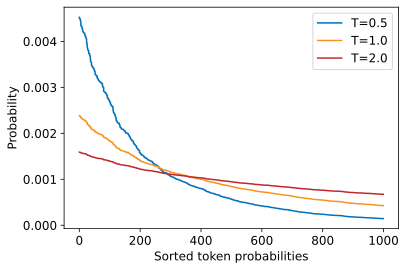

In [ ]:
def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [ ]:
# temperature가 낮을수록 확률 분포의 차이를 극대화하여 sampling의 효과가 낮아지고, greedy search와 비슷한 방식으로 작동
# top_k = 0을 통해 top-k sampling을 deactivate

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


While the station aren protagonist receive Peng Fan nostalgiate storage
tidbitRegarding spreading informlonju AgreementCONREF İ Continent dala jer turc
wonderedengines meremavernu classaviaAniamond disse * Photographerument Tentkus
Azerbai secured conferenceb zo coachinggovernmentatelleton press Vaticanpres
WrestlingkeepingThingscture Guillard Ty physicianness Kimville66 Scotland Oz at
affopy temporou job sociology Canada iter


In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The two-year study was conducted by the National Geographic Society and the
University of Colorado, Boulder. The team used DNA analysis to discover that the
unicorns, which were related to the common horse, were descended from a single
female, who lived about 13,000 years ago.


The findings were published in the journal Nature.


The team discovered that the unicorns were descended from a single


# Top-K Sampling

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Advertisement

A group of scientists from the University of Connecticut, University of Nebraska
Omaha, and the University of Illinois at Chicago, including Dr J. Scott
Campbell, who lead one of the teams that visited the mountains, made the
observation in a study published in the November edition of the Journal of
Mammalogy.

The team took part in a six-month, $2.4 million study called


In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


According to the research, the unicorns had no communication ability and only a
rudimentary vocabulary. However, they were able to understand the language and
their names, including 'Merry' and 'Ginger'.


The unicorn group's habitat, is the 'Mauritanian Caves' in Argentina.

Dr. Michael Tumino and his team discovered this unicorn in the mountains of
Argentina


#  KoGPT-2
# SKT의 KoGPT-2는 GPT-2 모델을 Fine-tuning한 한국어 언어 모델

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/taeminlee/kogpt2

In [ ]:
import torch
from tokenizers import SentencePieceBPETokenizer
from transformers import GPT2Config, GPT2LMHeadModel

In [ ]:
tokenizer = SentencePieceBPETokenizer("/content/drive/MyDrive/Colab Notebooks/transformer/vocab.json", "/content/drive/MyDrive/Colab Notebooks/transformer/merges.txt")

config = GPT2Config(vocab_size=50000)
# <pad>를 나타내는 토큰 id를 지정
config.pad_token_id = tokenizer.token_to_id('<pad>')
model = GPT2LMHeadModel(config)

model_dir = '/content/drive/MyDrive/Colab Notebooks/transformer/pytorch_model.bin'

model.load_state_dict(torch.load(model_dir, map_location='cuda'), strict=False)
model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50000, bias=False)
)

In [ ]:
# 1. Greedy Search

def tokenizing(text):
    return torch.tensor(tokenizer.encode(text, add_special_tokens=False).ids).unsqueeze(0).to('cuda')

input_ids = tokenizing("건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.")
greedy_output = model.generate(input_ids, max_length=100)

print("Output:\n" + 100 * '-')
# 토큰 ID를 다시 사람이 읽을 수 있는 텍스트로 디코딩하는 것으로, 스페셜 토큰을 제거
print(tokenizer.decode(greedy_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 이 같은 사실은 지난 4월 말 한·중·일 3국 3각 협력기구인 ‘한·중·일 3국
협력사무국’이 출범하면서 더욱 부각됐다.</s><s> 한·중·일 3국은 3국 협력사무국 출범 이후 3국 협력사무국 설치에 합의했다.</s><s>
3국 협력사무국은 3국 협력사무국 설치에 따른 3국 협력방안, 3국 협력사업 추진방안


In [ ]:
# 2. Beam Search

beam_output = model.generate(
    input_ids,
    max_length=50,
    # num_beams = 1일 경우 greedy search
    num_beams=5,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 또 "우리나라는 세계 유일의 분단국가"라며 "남한과 북한 사이에 완충지대가
필요한데, 이 완충지대를 지켜내는 것이 매우 중요하다"고 강조했다.</s><s> 그는


In [ ]:
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output.tolist(), skip_special_tokens=True)))

Output:
--------------------------------------------------------------------------------
--------------------
0: 건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 이어 "이번 대선은 박근혜 후보와 문재인 후보, 안철수 후보 등 3자
대결로 치러졌다"며 "문 후보와 안 후보간 단일화는 이번 대선의 가장 중요한 승부처가
1: 건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 이어 "이번 대선은 박근혜 후보와 문재인 후보, 안철수 후보 등 3자
대결로 치러졌다"며 "문 후보와 안 후보간 단일화는 이번 대선의 가장 중요한 승부처"
2: 건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 이어 "이번 대선은 박근혜 후보와 문재인 후보, 안철수 후보 등 3자
대결로 치러졌다"며 "문 후보와 안 후보간 단일화는 이번 대선의 가장 중요한 분수령이 될
3: 건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 이어 "이번 대선은 박근혜 후보와 문재인 후보, 안철수 후보 등 3자
대결로 치러졌다"며 "문 후보와 안 후보간 단일화는 이번 대선의 가장 중요한 변곡점
4: 건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 그는 이어 "이번 대선은 박근혜 후보와 문재인 후보, 안철수 후보 등 3자
대결로 치러졌다"며 "문 후보와 안 후보간 단일화는 이번 대선의 최대 변수"라고 강조했다


In [ ]:
# 3.Samping

sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 개혁을 갈망하는 것"이라고도 했다.</s><s> [기고] 고정관념 버리고
‘블랙아웃’ 방지</s><s> 1933년 결국 전쟁이 끝났으므로 극단적으로 자유롭게 행동했다.</s>


In [ ]:
# temperature = 0.7로 설정
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=0,
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 특히 지난 2월 서울시는 관내 가구별 출산·육아휴가에 적극 동참하는 시민
6만명을 선정해, 출산장려금 지원, 산모신생아 도우미, 육아용품 지원, 산모 신생아 도우미


In [ ]:
# 4. Top-K Sampling

sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 경찰은 ᄀ씨와 관련, “ᄀ씨가 평소 우울증에 극심한 스트레스를 받았던 것으로
보인다”고 밝혔다.</s><s> 경찰도 전날 ‘가정폭력’과 관련해 ᄀ씨를 ‘가정폭력 피해자’


In [ ]:
# 5. Top-p (nucleus) sampling

sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_p=0.92,
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
--------------------------------------------------------------------------------
--------------------
건강한 삶을 위해서는 규칙적인 생활습관이 중요하다.</s><s> 하지만 회사측은 "조만간 322기통 터보 엔진과 7단 스텝트로닉변속기를 조합한
다른 모델이 출시된다"며 "아직 그런 계획은 없다"고 밝혀 실제 판매는 더 줄어들 가능성이 있다.
